In [299]:
# 1. 데이터 전처리 관련 모듈 import
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from scipy.stats import boxcox

# 2. 데이터 분할
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, cross_val_predict, cross_validate, StratifiedKFold

# 3. 사용할 알고리즘 import
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.inspection import PartialDependenceDisplay

from xgboost import XGBRegressor

# 4. 성능 평가
from sklearn.metrics import r2_score, mean_absolute_percentage_error #, root_mean_squared_error, root_mean_squared_log_error

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pickle
import shap
import datetime as dt
import joblib

def getScore(name, y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
#     rmse = root_mean_squared_error(y_test, y_pred)
    # rmsle = root_mean_squared_log_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
#     print(f'{name}, r2: {r2:.3f}, mape: {mape:.3f}, rmse: {rmse:.3f}')
    print(f'{name}, r2: {r2:.3f}, mape: {mape:.3f}')

In [557]:
def convert_df(df_input):
    # VR Feed 관련 열: [118:152]
    df_input_vr_feed = df_input.iloc[:, 118:152]
    
    # 의미없는 맨 첫 열 제거하고 두번째 열을 column 이름으로 사용
    df_input_vr_feed.columns = df_input_vr_feed.iloc[0]
    df_input_vr_feed = df_input_vr_feed[1:].reset_index(drop=True)
    
    # 제거할 열: 0, 2, 5, 7,11, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33 + SEDEX
    col_to_drop = df_input_vr_feed.columns[[0, 2, 5, 7,11, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33]]
    df_input_vr_feed.drop(col_to_drop, axis=1, inplace=True)
    df_input_vr_feed.drop('SEDEX', axis=1, inplace=True)
    # df dtype 변경
    for col in df_input_vr_feed.columns:
        df_input_vr_feed[col] = df_input_vr_feed[col].astype('float64')
    
    # 결측치는 평균으로 채우기
    for col in df_input_vr_feed.columns:
        df_input_vr_feed[col].fillna(df_input_vr_feed[col].mean(), inplace=True)
    
    # 위 df에 2024년 평균 운전 데이터를 merge
    # 먼저 2024년 평균 운전 데이터를 df로 구성
    df = pd.read_csv('df_38thtrial.csv')
    df['Datetime'] = df['Datetime'].astype('datetime64[ns]')
    df.set_index('Datetime', drop=True, inplace=True)
    df = df.loc[df.index.year == 2024]
    opavg2024_list = []
    for col in df.columns[:15]:
        opavg2024_list.append(df[col].mean())
    opavg2024_df = pd.merge(pd.DataFrame(df.columns[:15]), pd.DataFrame(opavg2024_list), left_index=True, right_index=True)
    opavg2024_df.columns = ['variable', 'avg']
    opavg2024_df_t = opavg2024_df.transpose()
    opavg2024_df_t.columns = opavg2024_df_t.iloc[0]
    opavg2024_df_t = opavg2024_df_t[1:].reset_index(drop=True)
    opavg2024_df_t_repeated = pd.DataFrame([opavg2024_df_t.iloc[0]] * len(df_input_vr_feed), columns=opavg2024_df_t.columns)
    opavg2024_df_t_repeated.reset_index(drop=True, inplace=True)
    
    df = pd.concat([opavg2024_df_t_repeated, df_input_vr_feed], axis=1)
    return df
    # 이후 scaler.pkl을 이용한 표준화, Ni, V에 대한 pca 및 ni, v 제거, vis100을 sqrt 변환해야 SHFT 예측 가능함

## vis100 - sqrt transformation

In [584]:
df = pd.read_csv('./df_38thtrial.csv', index_col = 'Datetime')
df.drop(['SEDEX', 'N_S_r'], axis=1, inplace=True)
df['vis100_sqrt'] = np.sqrt(df['V(100) cSt.'])
# 나중에 sedex, NSratio 빠진 df 새로 저장하자

In [654]:
df.shape

(2241, 27)

In [585]:
# modeling - x 데이터로 V(100) 대신 sqrt v100
x = df.drop(['SHFT_avg', 'V(100) cSt.'], axis=1)
y = df['SHFT_avg']

# standard scaling - 최초 1회 수행
scaler = StandardScaler()
scaler.fit(x)  # Only fit on the training data
x_scaled = pd.DataFrame(scaler.transform(x), columns=x.columns)
# scaler 함수 pkl로 추출
joblib.dump(scaler, 'scaler.pkl')

# pca - 최초 1회 수행
pca = PCA(n_components=1)  # Keep one principal component
pca.fit(x_scaled[['Ni ppm', 'V ppm']])
x_pca = pca.transform(x_scaled[['Ni ppm', 'V ppm']])
x_scaled['Ni_V_PCA'] = x_pca
x_scaled.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# pca 함수 pkl로 추출
joblib.dump(pca, 'pca.pkl')

# scaler, pca는 동일한 모델 사용
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')
x_scaled = pd.DataFrame(scaler.transform(x), columns=x.columns)
x_pca = pca.transform(x_scaled[['Ni ppm', 'V ppm']])
x_scaled['Ni_V_PCA'] = x_pca
x_scaled.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)

# train/validation/test split
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y, test_size=0.4, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)
x_train_val = pd.concat([x_train, x_val])
y_train_val = pd.concat([y_train, y_val])

# model = linear regression
lr = LinearRegression()

# 1. cross validation을 통해 모델 성능 1차 확인
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scores_lr = cross_val_score(lr, x_train, y_train, cv=kfold, scoring='r2', error_score='raise')
print("LR Cross-Validation Scores:", scores_lr)
print("LR CV Average Score:", scores_lr.mean())

# 2. cross validation 결과 만족
# -> cross validation 및 hyper parameter tuning(미수행)을 통해 얻은 모델을 바탕으로 validation set에 대한 성능 확인
lr.fit(x_train, y_train)
y_val_pred_lr = lr.predict(x_val)
getScore('lr_validation', y_val, y_val_pred_lr)

# 3. validation set에 대한 성능 확인 결과 만족
# -> train+validation set으로 모델 학습한 뒤 test set에 대한 성능 최종 확인
lr.fit(x_train_val, y_train_val)
y_test_pred_lr = lr.predict(x_test)
getScore('lr_test', y_test, y_test_pred_lr)
# lr 함수 pkl로 추출
joblib.dump(lr, 'lr.pkl')

LR Cross-Validation Scores: [0.62230322 0.36481207 0.38659103 0.4298068  0.399894   0.36204917
 0.54711056 0.61769412 0.35720009 0.53044631]
LR CV Average Score: 0.4617907361386642
lr_validation, r2: 0.364, mape: 0.281
lr_test, r2: 0.484, mape: 0.270


['lr.pkl']

<AxesSubplot:xlabel='features'>

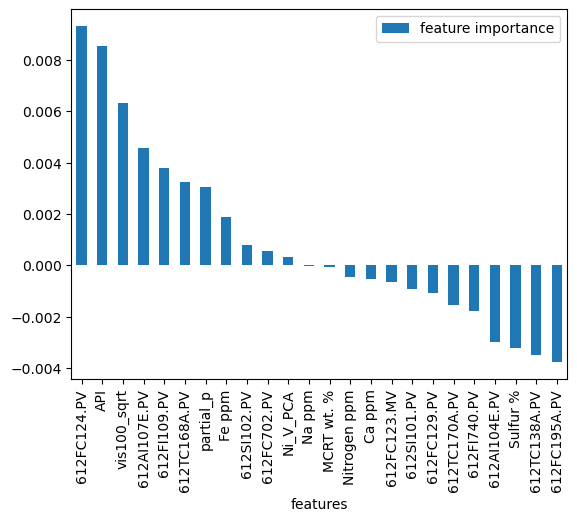

In [586]:
lr_importance = lr.coef_
fi_df_lr = pd.DataFrame({'features':x_scaled.columns, 'feature importance':lr_importance})
fi_df_lr.sort_values(by='feature importance',ascending=False).plot(kind='bar', x='features')

<AxesSubplot:xlabel='V(100) cSt.', ylabel='SHFT_avg'>

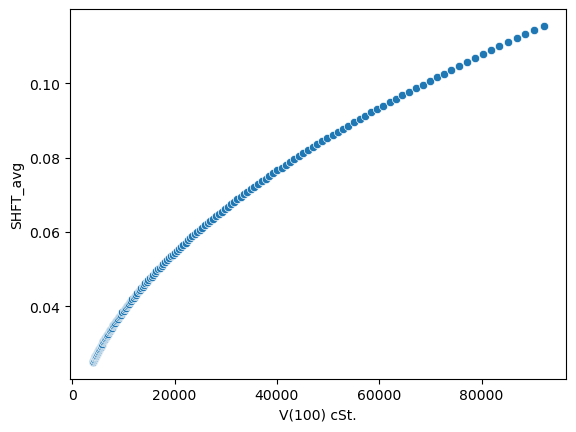

In [587]:
# 임의의 input file(assay)에 대해 df 변형 후 prediction까지 수행해보자 - vis
# load original assay
df_assay = pd.read_csv('./Assay Summary_visco.csv', encoding='cp949')
# assay -> df 
df_assay = convert_df(df_assay)
df_assay_original = df_assay.copy()
df_assay_feedonly = df_assay_original.loc[:,'API':]

# df에서 vis100_sqrt 추가 후 vis100 제거
df_assay['vis100_sqrt'] = np.sqrt(df_assay['V(100) cSt.'])
df_assay.drop('V(100) cSt.', axis=1, inplace=True)

# scaling
scaler = joblib.load('scaler.pkl')
df_assay = pd.DataFrame(scaler.transform(df_assay), columns=x.columns)
# pca
pca = joblib.load('pca.pkl')
df_assay_pca = pca.transform(df_assay[['Ni ppm', 'V ppm']])
df_assay['Ni_V_PCA'] = df_assay_pca
df_assay.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# prediction
lr = joblib.load('lr.pkl')
df_assay_SHFT = pd.DataFrame({'SHFT_avg':lr.predict(df_assay)})
df_assay_combined = pd.merge(df_assay_SHFT, df_assay_feedonly, left_index=True, right_index=True)
sns.scatterplot(data=df_assay_combined, x='V(100) cSt.', y='SHFT_avg')

<AxesSubplot:xlabel='V(100) cSt.', ylabel='SHFT_avg'>

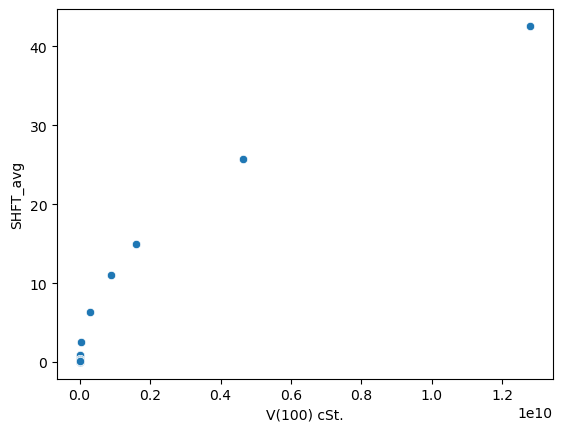

In [588]:
# 임의의 input file(assay)에 대해 df 변형 후 prediction까지 수행해보자 - original 
# load original assay
df_assay = pd.read_csv('./Assay Summary_original.csv', encoding='cp949')
# assay -> df 
df_assay = convert_df(df_assay)
df_assay_original = df_assay.copy()
df_assay_feedonly = df_assay_original.loc[:,'API':]

# df에서 vis100_sqrt 추가 후 vis100 제거
df_assay['vis100_sqrt'] = np.sqrt(df_assay['V(100) cSt.'])
df_assay.drop('V(100) cSt.', axis=1, inplace=True)

# scaling
scaler = joblib.load('scaler.pkl')
df_assay = pd.DataFrame(scaler.transform(df_assay), columns=x.columns)
# pca
pca = joblib.load('pca.pkl')
df_assay_pca = pca.transform(df_assay[['Ni ppm', 'V ppm']])
df_assay['Ni_V_PCA'] = df_assay_pca
df_assay.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# prediction
lr = joblib.load('lr.pkl')
df_assay_SHFT = pd.DataFrame({'SHFT_avg':lr.predict(df_assay)})
df_assay_combined = pd.merge(df_assay_SHFT, df_assay_feedonly, left_index=True, right_index=True)
df_assay_combined['vis100_sqrt'] = np.sqrt(df_assay_combined['V(100) cSt.'])
sns.scatterplot(data=df_assay_combined, x='V(100) cSt.', y='SHFT_avg')


In [589]:
df_assay_combined.sort_values(by='SHFT_avg', ascending=False).head(17)

,SHFT_avg,API,Sulfur %,Nitrogen ppm,MCRT wt. %,Ni ppm,V ppm,Na ppm,Fe ppm,Ca ppm,V(100) cSt.,vis100_sqrt
116,42.593684,-1.9,0.2,2902.0,16.7,13.3,1.2,87.300000,49.8,68.800000,1.279727e+10,113125.014917
152,25.718440,1.4,0.4,3766.0,20.2,12.9,1.6,18.584466,53.4,16.793204,4.643701e+09,68144.708320
74,14.908189,-3.5,6.7,5612.0,32.2,88.9,488.9,0.700000,1.3,3.000000,1.588689e+09,39858.363664
101,11.035212,-5.1,12.6,2799.0,37.0,67.7,178.2,3.100000,1.2,3.600000,8.888629e+08,29813.803364
145,6.397513,-0.2,2.6,7482.0,32.2,138.1,435.0,0.000000,12.3,21.600000,2.895946e+08,17017.478162
13,2.496486,3.8,0.3,2653.0,6.8,0.8,0.1,18.584466,5.7,16.793204,4.168153e+07,6456.123450
32,0.958680,-0.3,3.0,6587.0,36.4,119.5,416.9,0.000000,6.5,2.900000,6.646102e+06,2578.003491
134,0.863329,2.4,6.6,3528.0,42.1,26.4,30.4,18.584466,3.4,16.793204,5.644839e+06,2375.886992
76,0.782978,0.2,4.3,8946.0,31.1,146.4,581.1,11.300000,8.7,17.900000,4.620984e+06,2149.647413
115,0.726995,11.7,0.4,2495.0,17.4,25.0,0.3,18.584466,878.9,16.793204,1.302000e+03,36.083237


In [590]:
# 상위 3% assay = 상위 5개 assay <==> SHFT 2.5 % 이상
# 상위 5% assay <==> SHFT 0.8 % 이상
# 상위 10개 assay <==> SHFT 0.7 % 이상
# 상위 10% assay <==> SHFT 0.37 % 이상
len(df_assay_combined)*0.03, len(df_assay_combined)*0.05, len(df_assay_combined)*0.10

(4.77, 7.95, 15.9)

In [653]:
df_assay_info = pd.read_csv('./Assay Summary_original.csv', encoding='cp949')
df_assay_info.columns = df_assay_info.iloc[0]
df_assay_info = df_assay_info[1:].reset_index(drop=True)
df_assay_info = df_assay_info[['Feedstock', 'Feedstock코드','Origin']]
df_assay_combined_with_info = pd.merge(df_assay_info, df_assay_combined, left_index=True, right_index=True)
df_assay_combined_output = df_assay_combined_with_info.sort_values(by='SHFT_avg', ascending=False)
df_assay_combined_output.reset_index(drop=True, inplace=True)
df_assay_combined_output.rename(columns={'SHFT_avg':'SHFT 영향성'},inplace=True)
df_assay_combined_output['SHFT 영향성'] = df_assay_combined_output['SHFT 영향성']/df_assay_combined_output['SHFT 영향성'].median()
df_assay_combined_output = df_assay_combined_output.iloc[:,:-1]
df_assay_combined_output.to_csv('df_assay_info.csv', index=False)
df_assay_combined_output = pd.read_csv('./df_assay_info.csv')
df_assay_combined_output

,Feedstock,Feedstock코드,Origin,SHFT 영향성,API,Sulfur %,Nitrogen ppm,MCRT wt. %,Ni ppm,V ppm,Na ppm,Fe ppm,Ca ppm,V(100) cSt.
0,Sepinggan,SEP,Indonesia,256.833744,-1.9,0.2,2902.0,16.7,13.3,1.2,87.300000,49.8,68.800000,1.279727e+10
1,West Seno,WSN,Indonesia,155.078469,1.4,0.4,3766.0,20.2,12.9,1.6,18.584466,53.4,16.793204,4.643701e+09
2,Maya,MYA,Mexico,89.894223,-3.5,6.7,5612.0,32.2,88.9,488.9,0.700000,1.3,3.000000,1.588689e+09
3,Qaiyarah,QAH,Iraq,66.540732,-5.1,12.6,2799.0,37.0,67.7,178.2,3.100000,1.2,3.600000,8.888629e+08
4,Vasconia,VAS,Colombia,38.576074,-0.2,2.6,7482.0,32.2,138.1,435.0,0.000000,12.3,21.600000,2.895946e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,Walio,WAL,Indonesia,0.258084,0.8,3.0,8151.0,25.8,104.9,127.0,0.700000,12.7,14.900000,1.598200e+04
155,Bitumen Mixture_Exxon(Singapore),BMX,Unknown,0.231683,3.3,4.9,3595.0,27.7,48.0,152.6,15.800000,26.7,58.800000,9.053000e+03
156,Basrah Light,BAS,Iraq,0.223732,3.8,5.9,4676.0,23.9,45.5,163.7,0.000000,3.5,0.000000,8.313000e+03
157,Basrah Medium,BMT,Iraq,0.201393,1.1,6.5,3498.0,26.5,57.8,210.9,26.100000,11.0,53.400000,5.041500e+04


## vis100_sqrt_sqrt (기각)

In [459]:
df = pd.read_csv('./df_38thtrial.csv', index_col = 'Datetime')
df['vis100_sqrt2'] = np.sqrt(np.sqrt(df['V(100) cSt.']))

LR Cross-Validation Scores: [0.62364164 0.36030571 0.38518358 0.42666326 0.39647835 0.36277274
 0.54523278 0.61597934 0.35288227 0.52863561]
LR CV Average Score: 0.4597775290785596
lr_validation, r2: 0.365, mape: 0.281
lr_test, r2: 0.482, mape: 0.272


<AxesSubplot:xlabel='features'>

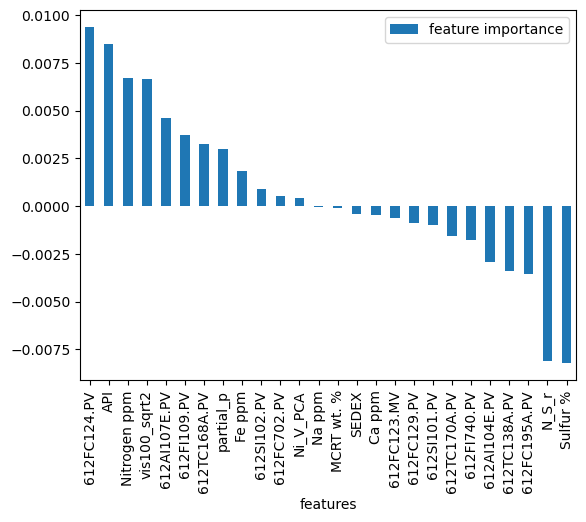

In [460]:
# modeling - x 데이터로 V(100) 대신 vis100_sqrt 사용
x = df.drop(['SHFT_avg', 'V(100) cSt.'], axis=1)
y = df['SHFT_avg']

# standard scaling - 최초 1회 수행
scaler = StandardScaler()
scaler.fit(x)  # Only fit on the training data
x_scaled = pd.DataFrame(scaler.transform(x), columns=x.columns)
# scaler 함수 pkl로 추출
joblib.dump(scaler, 'scaler.pkl')

# pca - 최초 1회 수행
pca = PCA(n_components=1)  # Keep one principal component
pca.fit(x_scaled[['Ni ppm', 'V ppm']])
x_pca = pca.transform(x_scaled[['Ni ppm', 'V ppm']])
x_scaled['Ni_V_PCA'] = x_pca
x_scaled.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# pca 함수 pkl로 추출
joblib.dump(pca, 'pca.pkl')

# scaler, pca는 동일한 모델 사용
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')
x_scaled = pd.DataFrame(scaler.transform(x), columns=x.columns)
x_pca = pca.transform(x_scaled[['Ni ppm', 'V ppm']])
x_scaled['Ni_V_PCA'] = x_pca
x_scaled.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)

# train/validation/test split
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y, test_size=0.4, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)
# print(x_train.shape, x_val.shape, x_test.shape)
# print(y_train.shape, y_val.shape, y_test.shape)
x_train_val = pd.concat([x_train, x_val])
y_train_val = pd.concat([y_train, y_val])

# model = linear regression
lr = LinearRegression()

# 1. cross validation을 통해 모델 성능 1차 확인
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scores_lr = cross_val_score(lr, x_train, y_train, cv=kfold, scoring='r2', error_score='raise')
print("LR Cross-Validation Scores:", scores_lr)
print("LR CV Average Score:", scores_lr.mean())

# 2. cross validation 결과 만족
# -> cross validation 및 hyper parameter tuning(미수행)을 통해 얻은 모델을 바탕으로 validation set에 대한 성능 확인
lr.fit(x_train, y_train)
y_val_pred_lr = lr.predict(x_val)
getScore('lr_validation', y_val, y_val_pred_lr)

# 3. validation set에 대한 성능 확인 결과 만족
# -> train+validation set으로 모델 학습한 뒤 test set에 대한 성능 최종 확인
lr.fit(x_train_val, y_train_val)
y_test_pred_lr = lr.predict(x_test)
getScore('lr_test', y_test, y_test_pred_lr)
# lr 함수 pkl로 추출
joblib.dump(lr, 'lr.pkl')

lr_importance = lr.coef_
fi_df_lr = pd.DataFrame({'features':x_scaled.columns, 'feature importance':lr_importance})
fi_df_lr.sort_values(by='feature importance',ascending=False).plot(kind='bar', x='features')

<AxesSubplot:xlabel='V(100) cSt.', ylabel='SHFT_avg'>

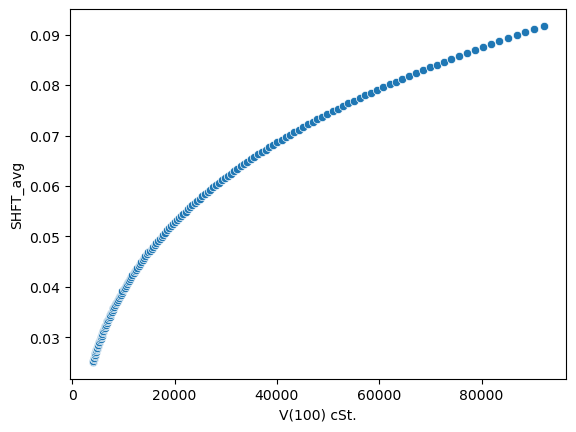

In [465]:
# 임의의 input file(assay)에 대해 df 변형 후 prediction까지 수행해보자 - vis
# load original assay
df_assay = pd.read_csv('./Assay Summary_visco.csv', encoding='cp949')
# assay -> df 
df_assay = convert_df(df_assay)
df_assay_original = df_assay.copy()
df_assay_feedonly = df_assay_original.loc[:,'API':]

# df에서 vis100_sqrt 추가 후 vis100 제거
df_assay['vis100_sqrt2'] = np.sqrt(np.sqrt(df_assay['V(100) cSt.']))
df_assay.drop('V(100) cSt.', axis=1, inplace=True)

# scaling
scaler = joblib.load('scaler.pkl')
df_assay = pd.DataFrame(scaler.transform(df_assay), columns=x.columns)
# pca
pca = joblib.load('pca.pkl')
df_assay_pca = pca.transform(df_assay[['Ni ppm', 'V ppm']])
df_assay['Ni_V_PCA'] = df_assay_pca
df_assay.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# prediction
lr = joblib.load('lr.pkl')
df_assay_SHFT = pd.DataFrame({'SHFT_avg':lr.predict(df_assay)})
df_assay_combined = pd.merge(df_assay_SHFT, df_assay_feedonly, left_index=True, right_index=True)
sns.scatterplot(data=df_assay_combined, x='V(100) cSt.', y='SHFT_avg')

<AxesSubplot:>

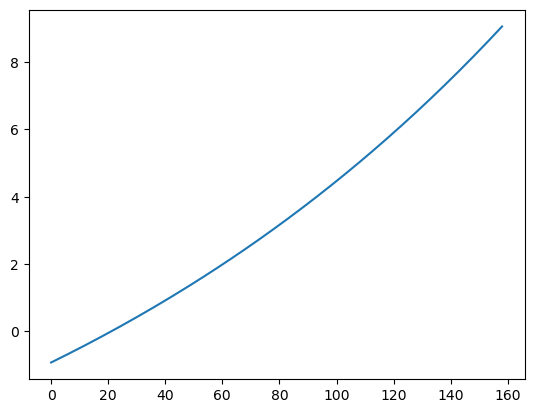

In [467]:
df_assay['vis100_sqrt2'].plot()

<AxesSubplot:xlabel='V(100) cSt.', ylabel='SHFT_avg'>

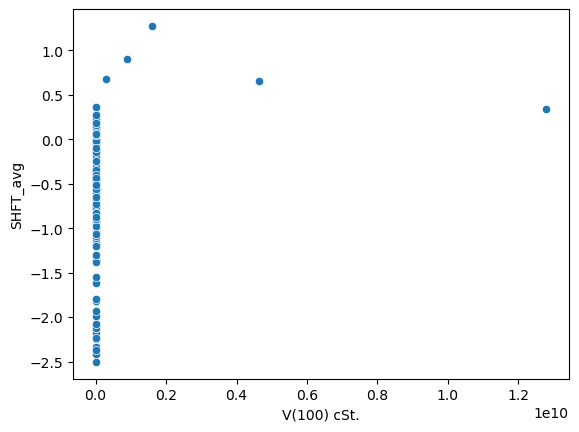

In [462]:
# 임의의 input file(assay)에 대해 df 변형 후 prediction까지 수행해보자 - original 
# load original assay
df_assay = pd.read_csv('./Assay Summary_original.csv', encoding='cp949')
# assay -> df 
df_assay = convert_df(df_assay)
df_assay_original = df_assay.copy()
df_assay_feedonly = df_assay_original.loc[:,'API':]

# df에서 vis100_sqrt 추가 후 vis100 제거
df_assay['vis100_sqrt2'] = np.sqrt(np.sqrt(df_assay['V(100) cSt.']))
df_assay.drop('V(100) cSt.', axis=1, inplace=True)

# scaling
scaler = joblib.load('scaler.pkl')
df_assay = pd.DataFrame(scaler.transform(df_assay), columns=x.columns)
# pca
pca = joblib.load('pca.pkl')
df_assay_pca = pca.transform(df_assay[['Ni ppm', 'V ppm']])
df_assay['Ni_V_PCA'] = df_assay_pca
df_assay.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# prediction
lr = joblib.load('lr.pkl')
df_assay_SHFT = pd.DataFrame({'SHFT_avg':lr.predict(df_assay)})
df_assay_combined = pd.merge(df_assay_SHFT, df_assay_feedonly, left_index=True, right_index=True)
df_assay_combined['vis100_sqrt2'] = np.sqrt(np.sqrt(df_assay_combined['V(100) cSt.']))
sns.scatterplot(data=df_assay_combined, x='V(100) cSt.', y='SHFT_avg')


<AxesSubplot:>

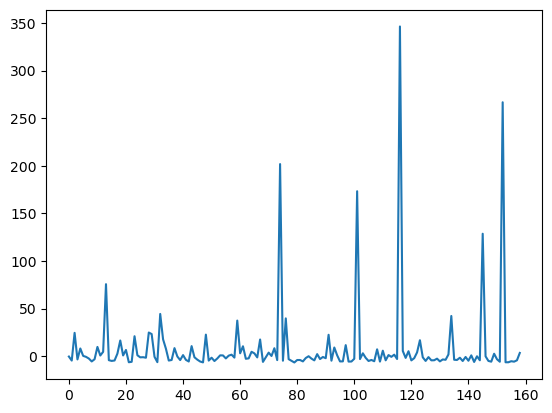

In [464]:
df_assay['vis100_sqrt2'].plot()

## vis100 - boxcox transformation (기각)

In [390]:
df = pd.read_csv('./df_38thtrial.csv', index_col = 'Datetime')
vis100_boxcox, lambda_value = boxcox(df['V(100) cSt.'])
print(lambda_value)
# lambda_value=0.5
df['vis100_boxcox'] = boxcox(df['V(100) cSt.'], lmbda=lambda_value)

0.21352747007261694


LR Cross-Validation Scores: [0.62375473 0.36009064 0.38496378 0.42690705 0.396114   0.36270579
 0.54519201 0.61585309 0.35255069 0.5284364 ]
LR CV Average Score: 0.4596568183915936
lr_validation, r2: 0.365, mape: 0.281
lr_test, r2: 0.482, mape: 0.272


<AxesSubplot:xlabel='features'>

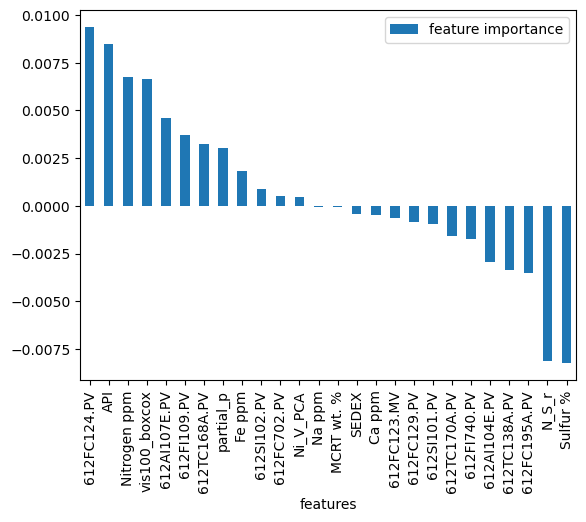

In [391]:
# modeling - x 데이터로 V(100) 대신 V(100)_boxcox를 사용
x = df.drop(['SHFT_avg', 'V(100) cSt.'], axis=1)
y = df['SHFT_avg']

# standard scaling - 최초 1회 수행
scaler = StandardScaler()
scaler.fit(x)  # Only fit on the training data
x_scaled = pd.DataFrame(scaler.transform(x), columns=x.columns)
# scaler 함수 pkl로 추출
joblib.dump(scaler, 'scaler.pkl')

# pca - 최초 1회 수행
pca = PCA(n_components=1)  # Keep one principal component
pca.fit(x_scaled[['Ni ppm', 'V ppm']])
x_pca = pca.transform(x_scaled[['Ni ppm', 'V ppm']])
x_scaled['Ni_V_PCA'] = x_pca
x_scaled.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# pca 함수 pkl로 추출
joblib.dump(pca, 'pca.pkl')

# scaler, pca는 동일한 모델 사용
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')
x_scaled = pd.DataFrame(scaler.transform(x), columns=x.columns)
x_pca = pca.transform(x_scaled[['Ni ppm', 'V ppm']])
x_scaled['Ni_V_PCA'] = x_pca
x_scaled.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)

# train/validation/test split
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y, test_size=0.4, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)
# print(x_train.shape, x_val.shape, x_test.shape)
# print(y_train.shape, y_val.shape, y_test.shape)
x_train_val = pd.concat([x_train, x_val])
y_train_val = pd.concat([y_train, y_val])

# model = linear regression
lr = LinearRegression()

# 1. cross validation을 통해 모델 성능 1차 확인
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scores_lr = cross_val_score(lr, x_train, y_train, cv=kfold, scoring='r2', error_score='raise')
print("LR Cross-Validation Scores:", scores_lr)
print("LR CV Average Score:", scores_lr.mean())

# 2. cross validation 결과 만족
# -> cross validation 및 hyper parameter tuning(미수행)을 통해 얻은 모델을 바탕으로 validation set에 대한 성능 확인
lr.fit(x_train, y_train)
y_val_pred_lr = lr.predict(x_val)
getScore('lr_validation', y_val, y_val_pred_lr)

# 3. validation set에 대한 성능 확인 결과 만족
# -> train+validation set으로 모델 학습한 뒤 test set에 대한 성능 최종 확인
lr.fit(x_train_val, y_train_val)
y_test_pred_lr = lr.predict(x_test)
getScore('lr_test', y_test, y_test_pred_lr)
# lr 함수 pkl로 추출
joblib.dump(lr, 'lr.pkl')

lr_importance = lr.coef_
fi_df_lr = pd.DataFrame({'features':x_scaled.columns, 'feature importance':lr_importance})
fi_df_lr.sort_values(by='feature importance',ascending=False).plot(kind='bar', x='features')

0.21352747007261694


<AxesSubplot:xlabel='V(100) cSt.', ylabel='SHFT_avg'>

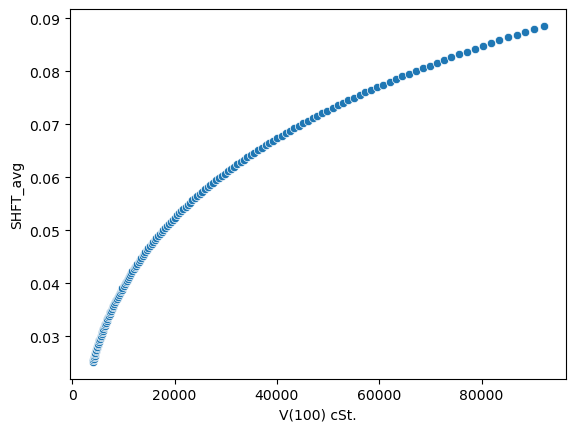

In [393]:
# 임의의 input file(assay)에 대해 df 변형 후 prediction까지 수행해보자 - vis
# load original assay
df_assay = pd.read_csv('./Assay Summary_visco.csv', encoding='cp949')
# assay -> df 
df_assay = convert_df(df_assay)
df_assay_original = df_assay.copy()
df_assay_feedonly = df_assay_original.loc[:,'API':]

# df에서 vis100_boxcox 추가 후 vis100 제거
print(lambda_value)
df_assay['vis100_boxcox'] = ((df_assay['V(100) cSt.'] ** lambda_value) - 1) / lambda_value
df_assay.drop('V(100) cSt.', axis=1, inplace=True)

# scaling
scaler = joblib.load('scaler.pkl')
df_assay = pd.DataFrame(scaler.transform(df_assay), columns=x.columns)
# pca
pca = joblib.load('pca.pkl')
df_assay_pca = pca.transform(df_assay[['Ni ppm', 'V ppm']])
df_assay['Ni_V_PCA'] = df_assay_pca
df_assay.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# prediction
lr = joblib.load('lr.pkl')
df_assay_SHFT = pd.DataFrame({'SHFT_avg':lr.predict(df_assay)})
df_assay_combined = pd.merge(df_assay_SHFT, df_assay_feedonly, left_index=True, right_index=True)
sns.scatterplot(data=df_assay_combined, x='V(100) cSt.', y='SHFT_avg')

<AxesSubplot:>

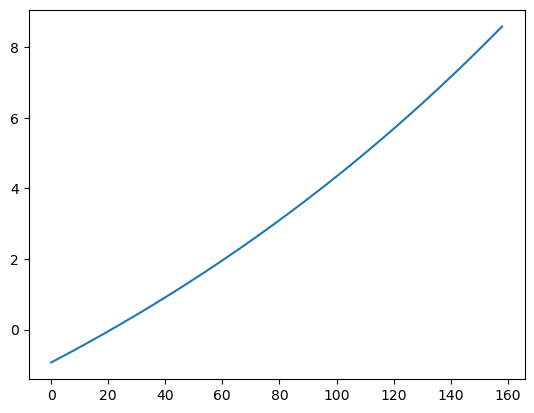

In [394]:
df_assay['vis100_boxcox'].plot()

<AxesSubplot:>

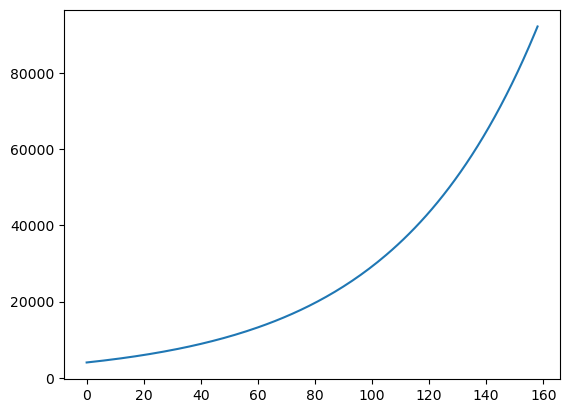

In [395]:
df_assay_original['V(100) cSt.'].plot()

<AxesSubplot:xlabel='V(100) cSt.', ylabel='SHFT_avg'>

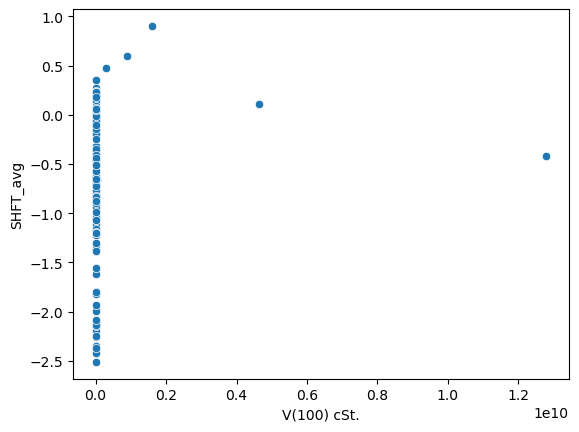

In [396]:
# 임의의 input file(assay)에 대해 df 변형 후 prediction까지 수행해보자 - original 
# load original assay
df_assay = pd.read_csv('./Assay Summary_original.csv', encoding='cp949')
# assay -> df 
df_assay = convert_df(df_assay)
df_assay_original = df_assay.copy()
df_assay_feedonly = df_assay_original.loc[:,'API':]

# df에서 vis100_boxcox 추가 후 vis100 제거
df_assay['vis100_boxcox'] = ((df_assay['V(100) cSt.'] ** lambda_value) - 1) / lambda_value
df_assay.drop('V(100) cSt.', axis=1, inplace=True)

# scaling
scaler = joblib.load('scaler.pkl')
df_assay = pd.DataFrame(scaler.transform(df_assay), columns=x.columns)
# pca
pca = joblib.load('pca.pkl')
df_assay_pca = pca.transform(df_assay[['Ni ppm', 'V ppm']])
df_assay['Ni_V_PCA'] = df_assay_pca
df_assay.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# prediction
lr = joblib.load('lr.pkl')
df_assay_SHFT = pd.DataFrame({'SHFT_avg':lr.predict(df_assay)})
df_assay_combined = pd.merge(df_assay_SHFT, df_assay_feedonly, left_index=True, right_index=True)
df_assay_combined['vis100_boxcox'] = ((df_assay_original['V(100) cSt.'] ** lambda_value) - 1) / lambda_value

sns.scatterplot(data=df_assay_combined, x='V(100) cSt.', y='SHFT_avg')


In [397]:
df_assay_combined.sort_values(by='SHFT_avg', ascending=False).head(10)

,SHFT_avg,API,Sulfur %,Nitrogen ppm,MCRT wt. %,Ni ppm,V ppm,SEDEX,Na ppm,Fe ppm,Ca ppm,V(100) cSt.,N_S_r,vis100_boxcox
74,0.903654,-3.5,6.7,5612.0,32.2,88.9,488.9,3.2,0.700000,1.3,3.000000,1.588689e+09,837.611940,427.055294
101,0.602109,-5.1,12.6,2799.0,37.0,67.7,178.2,0.6,3.100000,1.2,3.600000,8.888629e+08,222.142857,376.705876
145,0.473287,-0.2,2.6,7482.0,32.2,138.1,435.0,10.5,0.000000,12.3,21.600000,2.895946e+08,2877.692308,295.489290
156,0.356917,21.2,0.4,42.0,7.2,0.1,0.3,0.0,18.584466,0.6,16.793204,1.310000e+02,105.000000,8.579764
47,0.353004,27.0,0.3,199.0,1.9,0.7,0.6,0.0,13.100000,0.4,0.300000,4.900000e+01,663.333333,6.067779
68,0.271754,18.3,1.2,423.0,7.7,0.8,1.3,0.0,10.700000,0.8,0.900000,9.900000e+01,352.500000,7.809832
107,0.238182,7.6,2.5,2495.0,36.0,11.2,4.8,0.1,18.584466,305.8,16.793204,2.030000e+02,998.000000,9.880070
134,0.234449,2.4,6.6,3528.0,42.1,26.4,30.4,0.7,18.584466,3.4,16.793204,5.644839e+06,534.545455,124.798739
132,0.231235,15.6,2.4,901.0,10.5,19.3,7.9,0.0,18.584466,16.2,16.793204,7.560000e+02,375.416667,14.600433
59,0.208123,-0.1,5.4,3476.0,31.8,90.9,454.9,2.0,8.600000,5.1,7.300000,3.810215e+06,643.703704,114.375079


In [398]:
df_assay_combined.sort_values(by='V(100) cSt.', ascending=False).head(10)

,SHFT_avg,API,Sulfur %,Nitrogen ppm,MCRT wt. %,Ni ppm,V ppm,SEDEX,Na ppm,Fe ppm,Ca ppm,V(100) cSt.,N_S_r,vis100_boxcox
116,-0.416659,-1.9,0.2,2902.0,16.7,13.3,1.2,0.9,87.300000,49.8,68.800000,1.279727e+10,14510.000000,669.368809
152,0.112211,1.4,0.4,3766.0,20.2,12.9,1.6,0.5,18.584466,53.4,16.793204,4.643701e+09,9415.000000,538.176106
74,0.903654,-3.5,6.7,5612.0,32.2,88.9,488.9,3.2,0.700000,1.3,3.000000,1.588689e+09,837.611940,427.055294
101,0.602109,-5.1,12.6,2799.0,37.0,67.7,178.2,0.6,3.100000,1.2,3.600000,8.888629e+08,222.142857,376.705876
145,0.473287,-0.2,2.6,7482.0,32.2,138.1,435.0,10.5,0.000000,12.3,21.600000,2.895946e+08,2877.692308,295.489290
13,-0.658044,3.8,0.3,2653.0,6.8,0.8,0.1,0.0,18.584466,5.7,16.793204,4.168153e+07,8843.333333,193.749596
32,0.140231,-0.3,3.0,6587.0,36.4,119.5,416.9,9.9,0.000000,6.5,2.900000,6.646102e+06,2195.666667,129.392969
134,0.234449,2.4,6.6,3528.0,42.1,26.4,30.4,0.7,18.584466,3.4,16.793204,5.644839e+06,534.545455,124.798739
76,0.173119,0.2,4.3,8946.0,31.1,146.4,581.1,6.2,11.300000,8.7,17.900000,4.620984e+06,2080.465116,119.382006
59,0.208123,-0.1,5.4,3476.0,31.8,90.9,454.9,2.0,8.600000,5.1,7.300000,3.810215e+06,643.703704,114.375079


<AxesSubplot:>

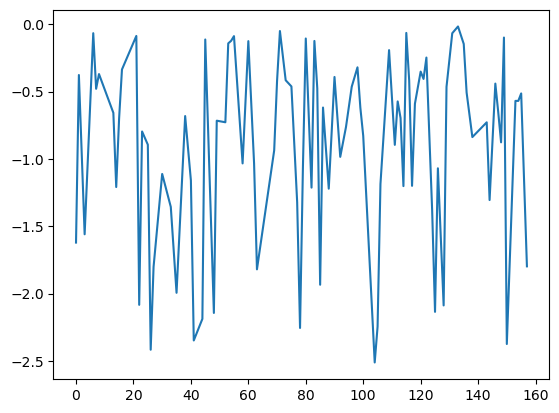

In [399]:
df_assay_combined.loc[df_assay_combined['SHFT_avg'] < 0]['SHFT_avg'].plot()

<AxesSubplot:>

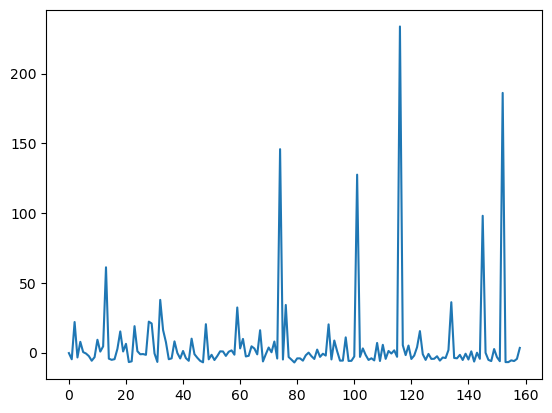

In [400]:
df_assay['vis100_boxcox'].plot()

In [438]:
sns.scatterplot(data=df_assay_combined, x='vis100_boxcox', y='SHFT_avg')

ValueError: Could not interpret value `vis100_boxcox` for parameter `x`